#### EP4130: Data Science Analysis

#### Assignment 7

#### Ranveer Sahu- ES21BTECH11025

**********

In [70]:
pip install emcee

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install corner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install dynesty

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [73]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import dynesty
from dynesty import NestedSampler
from sklearn.neighbors import KernelDensity as kde

***********

**Question 1**

Download the SPT fgas data from http://iith.ac.in/~shantanud/fgas_
spt.txt. Fit the data to f0 (1 + f1 z) where f0 and f1 are unknown constants. Determine the best fit values of f0 and f1 including 68% and 90% credible intervals using emcee and corner.py . The priors on f0 and f1 should be 0 < f0 < 0.5 and −0.5 < f1 < 0.5.

In [74]:
data = pd.read_csv("fgas_spt.txt")
z = data["z"]
f_gas = data["fgas"]
fgas_err = data["fgas_error"]

**defining log_prior:**

In [75]:
def log_prior(theta):
    f0 , f1 = theta
    if 0 < f0 < 0.5 and -0.5 < f1 < 0.5:
        return 0.0
    return -np.inf

**defining the log likelihood:**

In [76]:
def log_likelihood(theta, z, f_gas, fgas_err):
    f0, f1 = theta
    model = f0 + f1 * z
    return -0.5 * np.sum(((f_gas - model) / fgas_err)**2)

**definign the log posterior:**

In [77]:
def log_posterior(theta, z, f_gas, fgas_err):
    return log_prior(theta) + log_likelihood(theta, z, f_gas, fgas_err)

**running MCMC:**

In [78]:
nwalkers = 50
nsteps = 2000
ndim = 2 
nburn = 1000  

**initial guess for parameters:**

In [79]:
f0_guess = np.random.uniform(0 , 0.5 , nwalkers)
f1_guess = np.random.uniform(-0.5 , 0.5 , nwalkers)
initial = np.vstack((f0_guess , f1_guess)).T

**defining the sampler:**

In [80]:
sampler = emcee.EnsembleSampler(nwalkers , ndim , log_posterior , args = (z , f_gas , fgas_err))
sampler.run_mcmc(initial , nsteps)
samples = sampler.chain[: , nburn: , :].reshape(-1 , ndim)

**Plots:**

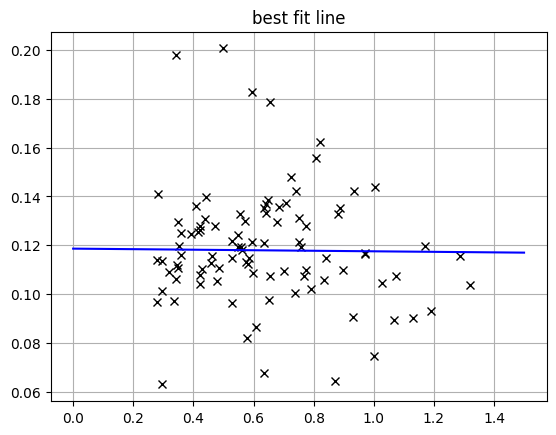

In [81]:
f0 = samples[:,0].mean()
f1 = samples[:,1].mean()
x = np.linspace(0,1.5,100)
plt.plot(z , f_gas , 'kx')
plt.title("best fit line")
plt.plot(x , f0 * (1 + f1*x) , 'b-')
plt.grid(True)
plt.show()

68% and 95% joint confidence intervals for f_0 and f_1


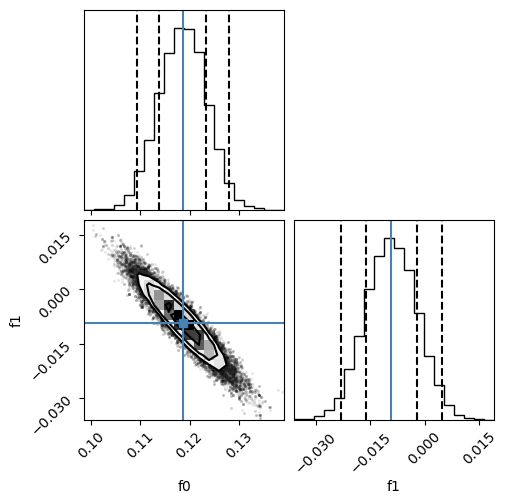

In [82]:
print("68% and 95% joint confidence intervals for f_0 and f_1")
corner.corner(samples , labels = ["f0" , "f1"] , truths = [f0 , f1] , quantiles = (0.16 , 0.84 , 0.025 , 0.975))
plt.show()

**********

**Question 2**

Calculate the Bayes factor for the linear and quadratic model for the example given on fifth blog article of the Pythonic Perambulations Series using dynesty or Nestle. Do the values agree with what’s on the blog(obtained by integrating the emcee samples).?

In [83]:
data = np.array([[0.42,  0.72,  0.,  0.3,  0.15,0.09,  0.19,  0.35,  0.4,  0.54,
                  0.42,  0.69,  0.2,  0.88,  0.03,0.67,  0.42,  0.56,  0.14,  0.2],
                 [0.33,  0.41, -0.22,  0.01, -0.05, -0.05, -0.12,  0.26,  0.29,  0.39,
                  0.31,  0.42, -0.01,  0.58, -0.2, 0.52,  0.15,  0.32, -0.13, -0.09],
                 [0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1,
                  0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1]])

x , y , sigma_y = data

**polynomial fit function:**

In [84]:
def polynomial_fit(theta):
    sum = 0
    for idx , coeff in enumerate(theta):
        sum += coeff * x ** idx
    return sum

**log likelihood function:**

In [85]:
def log_likelyhood(theta, data=data):
    pred = polynomial_fit(theta)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - pred) ** 2 / sigma_y ** 2)

**prior function:**

In [86]:
def prior(theta):
    return 200*theta - 100

In [87]:
# Taking reference from
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

In [88]:
sampler = NestedSampler(log_likelyhood, prior, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar

res = sampler.results # get results dictionary from sampler

logZdynesty_linear = res.logz[-1]        # value of logZ
logZerrdynesty_linear = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [89]:
print("log(Z) for the Linear Model = {} ± {}".format(logZdynesty_linear, logZerrdynesty_linear))

log(Z) for the Linear Model = 7.027910396437706 ± 0.14782896065052578


In [90]:
# Taking reference from
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # three parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

In [91]:
sampler = NestedSampler(log_likelyhood, prior, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar

res = sampler.results # get results dictionary from sampler

logZdynesty_quadratic = res.logz[-1]        # value of logZ
logZerrdynesty_quadratic = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [92]:
print("log(Z) for the Quad. Model = {} ± {}".format(logZdynesty_quadratic, logZerrdynesty_quadratic))

log(Z) for the Quad. Model = 2.5350348388325794 ± 0.17156736844087703


In [93]:
print("Bayes factor(quad. model):",format(np.exp(logZdynesty_quadratic) / np.exp(logZdynesty_linear)))

Bayes factor(quad. model): 0.01118842454832019


**************

**Question 3**

Download the SDSS quasar dataset from http://astrostatistics.psu.edu/datasets/SDSS_quasar.dat. Plot the KDE estimate of the quasar redshift distribution (the column with the title z) using a Gaussian and also an exponential kernel (with bandwidth=0.2) from -0.5 to 5.5. (20 points)(Hint: Look at the KDE help page in scikit-learn or use the corresponding functions in astroML module by looking at source code of astroML figures 6.3 and 6.4)

In [94]:
data = pd.read_csv("SDSS_quasar.txt" , sep = " ")
data

,SDSS_J,R.A.,Dec.,z,u_mag,sig_u,g_mag,sig_g,r_mag,sig_r,...,sig_z,Radio,X-ray,J_mag,sig_J,H_mag,sig_H,K_mag,sig_K,M_i
0,000009.26+151754.5,0.038605,15.298476,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,...,0.069,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.085
1,000009.38+135618.4,0.039088,13.938447,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,...,0.033,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-27.419
2,000009.42-102751.9,0.039269,-10.464428,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,...,0.047,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.459
3,000011.41+145545.6,0.047547,14.929353,0.4596,19.637,0.030,19.466,0.024,19.362,0.022,...,0.047,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-22.728
4,000011.96+000225.3,0.049842,0.040372,0.4790,18.237,0.028,17.971,0.020,18.025,0.019,...,0.029,0.0,-1.660,16.651,0.136,15.820,0.149,14.821,0.111,-24.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46415,235949.46+150430.6,359.956093,15.075185,0.2977,19.094,0.025,18.966,0.023,18.668,0.016,...,0.033,-1.0,-1.429,16.676,0.180,15.661,0.176,15.187,0.130,-22.286
46416,235953.44-093655.6,359.972672,-9.615454,0.3585,19.509,0.045,19.276,0.022,18.895,0.018,...,0.039,0.0,-9.000,16.976,0.173,16.188,0.164,15.502,0.238,-22.549
46417,235956.72+135131.7,359.986358,13.858825,2.3826,20.010,0.040,19.427,0.027,19.217,0.018,...,0.048,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.665
46418,235958.21+005139.8,359.992546,0.861062,2.0382,19.256,0.034,19.004,0.021,18.794,0.017,...,0.036,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.900


In [95]:
quasar = data["z"]
quasar = quasar.to_numpy().reshape(-1,1)
x = np.linspace(-0.5 , 5.5 , 1000)

gaussian_kde = kde(kernel = "gaussian" , bandwidth = 0.2).fit(quasar)
exponential_kde = kde(kernel = "exponential" , bandwidth = 0.2).fit(quasar)

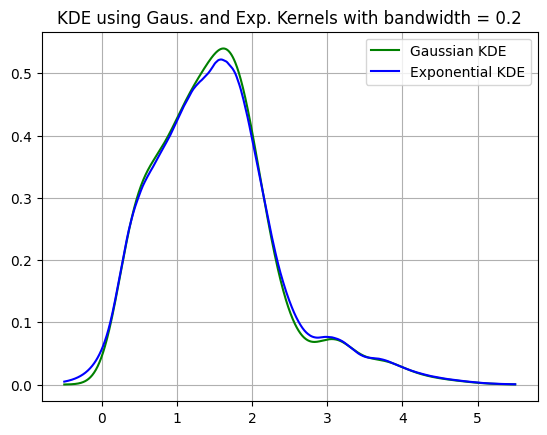

In [97]:
plt.plot(x , np.exp(gaussian_kde.score_samples(x.reshape(-1,1))) , 'g-' , label = "Gaussian KDE")
plt.plot(x , np.exp(exponential_kde.score_samples(x.reshape(-1,1))) , 'b-' , label = "Exponential KDE")
plt.grid(True)
plt.legend()
plt.title("KDE using Gaus. and Exp. Kernels with bandwidth = 0.2")
plt.show()

****
